In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import os

In [2]:
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick

#from maml.sampling.direct import BirchClustering, DIRECTSampler, SelectKFromClusters
from dpeva.sampling.direct import BirchClustering, DIRECTSampler, SelectKFromClusters

Initializing DP-EVA version 0.1.0


## Load descriptor example, 

descriptor shape : (nframe, ndim)

In [3]:
desc = np.load('../data/desc.npy')
desc.shape

(20873, 136)

## DIRECT sampling
Please refer to the DIRECT manuscript about setting n and k values. threshold_init is a parameter of Birch clustering method, which should be tuned to get desired n clusters. Some tuning is already built in, while a meaningful initial guess is needed. The default value of 0.5 is usually a good guess. It needs to be decreased if the number of clusters is below expectation, and vice versa.

In [4]:
%%time
DIRECT_sampler = DIRECTSampler(
    structure_encoder=None,
    clustering=BirchClustering(n=2000, threshold_init=0.05),
    select_k_from_clusters=SelectKFromClusters(k=1),
)

CPU times: user 24 μs, sys: 13 μs, total: 37 μs
Wall time: 40.8 μs


In [5]:
%%time
DIRECT_selection = DIRECT_sampler.fit_transform(desc)

2025-01-10 17:12:23,815 - dpeva.sampling.pca - INFO - Selected first 16 PCs, explaining 91.26% variance
2025-01-10 17:12:26,672 - dpeva.sampling.clustering - INFO - BirchClustering with threshold_init=0.05 and n=2000 gives 2000 clusters.
2025-01-10 17:12:26,756 - dpeva.sampling.stratified_sampling - INFO - Finally selected 2000 configurations.


CPU times: user 3.8 s, sys: 5.04 s, total: 8.84 s
Wall time: 3 s


In [6]:
# deal with the unweighted features and the explained variance
explained_variance = DIRECT_sampler.pca.pca.explained_variance_ratio_
DIRECT_selection["PCAfeatures_unweighted"] = DIRECT_selection["PCAfeatures"] / explained_variance[:16]
all_features = DIRECT_selection["PCAfeatures_unweighted"]
selected_indices = DIRECT_selection["selected_indices"]
len(selected_indices)

2000

## Manual sampling
Here we utilize the random way for raw manual sampling

In [7]:
import random
manual_selection_index = np.random.choice(range(len(all_features)), 2000, replace=False)

## Visualizing the coverage of feature space

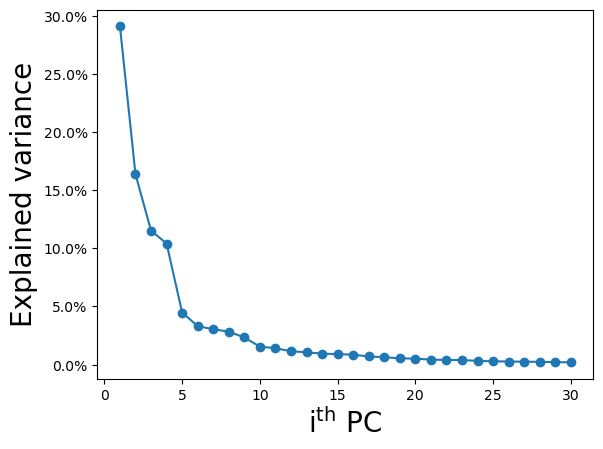

In [8]:
plt.plot(
    range(1, 31),
    explained_variance[:30] * 100,
    "o-",
)
plt.xlabel(r"i$^{\mathrm{th}}$ PC", size=20)
plt.ylabel("Explained variance", size=20)
ax = plt.gca()
ax.yaxis.set_major_formatter(mtick.PercentFormatter())

In [9]:
def plot_PCAfeature_coverage(all_features, selected_indices, method="DIRECT"):
    fig, ax = plt.subplots(figsize=(5, 5))
    selected_features = all_features[selected_indices]
    plt.plot(all_features[:, 0], all_features[:, 1], "*", alpha=0.5, label=f"All {len(all_features):,} structures")
    plt.plot(
        selected_features[:, 0],
        selected_features[:, 1],
        "*",
        alpha=0.5,
        label=f"{method} sampled {len(selected_features):,}",
    )
    legend = plt.legend(frameon=False, fontsize=14, loc="upper left", bbox_to_anchor=(-0.02, 1.02), reverse=True)
    for lh in legend.legendHandles:
        lh.set_alpha(1)
    plt.ylabel("PC 2", size=20)
    plt.xlabel("PC 1", size=20)

CPU times: user 12.3 ms, sys: 1.75 ms, total: 14 ms
Wall time: 13.1 ms


/tmp/ipykernel_9682/1745198056.py:13: MatplotlibDeprecationWarning: The legendHandles attribute was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use legend_handles instead.
  for lh in legend.legendHandles:


(-12.0, 15.0)

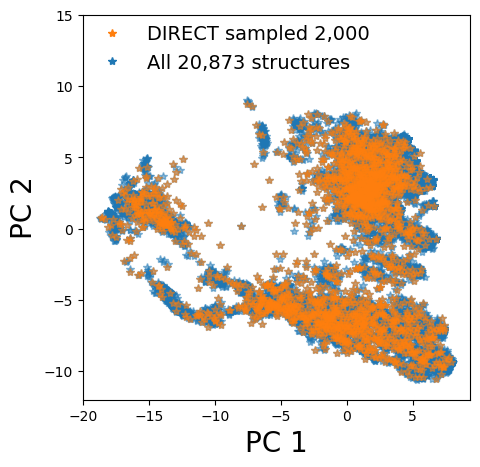

In [10]:
%%time
plot_PCAfeature_coverage(all_features, selected_indices)
plt.ylim(-12, 15)

In [11]:
def calculate_feature_coverage_score(all_features, selected_indices, n_bins=100):
    selected_features = all_features[selected_indices]
    n_all = np.count_nonzero(
        np.histogram(all_features, bins=np.linspace(min(all_features), max(all_features), n_bins))[0]
    )
    n_select = np.count_nonzero(
        np.histogram(selected_features, bins=np.linspace(min(all_features), max(all_features), n_bins))[0]
    )
    return n_select / n_all

In [12]:
def calculate_all_FCS(all_features, selected_indices, b_bins=100):
    select_scores = [
        calculate_feature_coverage_score(all_features[:, i], selected_indices, n_bins=b_bins)
        for i in range(all_features.shape[1])
    ]
    return select_scores

CPU times: user 12.5 ms, sys: 1.93 ms, total: 14.5 ms
Wall time: 13.6 ms


/tmp/ipykernel_9682/1745198056.py:13: MatplotlibDeprecationWarning: The legendHandles attribute was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use legend_handles instead.
  for lh in legend.legendHandles:


(-12.0, 15.0)

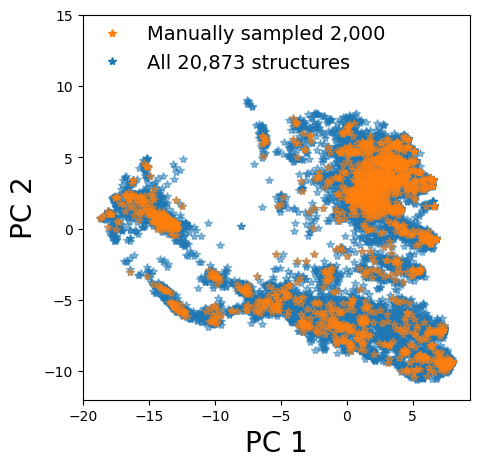

In [13]:
%%time
plot_PCAfeature_coverage(all_features, manual_selection_index, "Manually")
plt.ylim(-12, 15)

In [14]:
%%time
all_features = DIRECT_selection["PCAfeatures_unweighted"]
scores_DIRECT = calculate_all_FCS(all_features, DIRECT_selection["selected_indices"], b_bins=50)
scores_MS = calculate_all_FCS(all_features, manual_selection_index, b_bins=100)

CPU times: user 188 ms, sys: 0 ns, total: 188 ms
Wall time: 186 ms


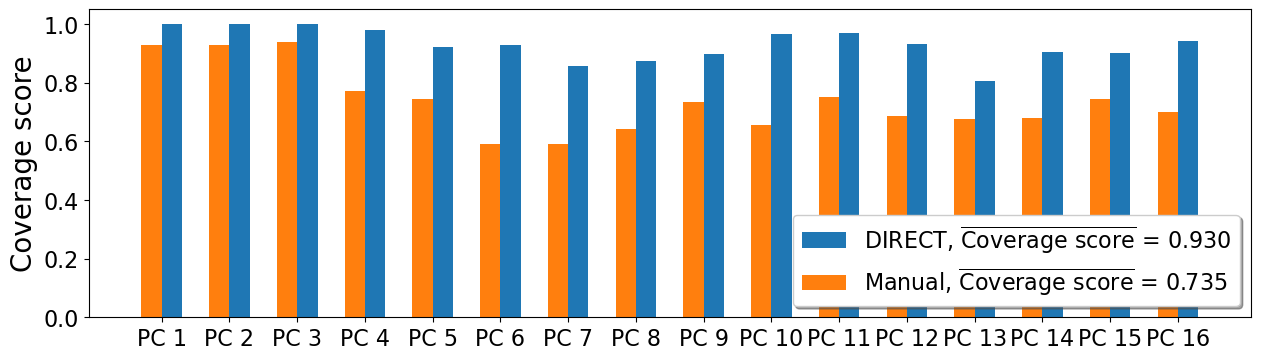

In [15]:
x = np.arange(len(scores_DIRECT))
x_ticks = [f"PC {n+1}" for n in range(len(x))]

plt.figure(figsize=(15, 4))
plt.bar(
    x + 0.6,
    scores_DIRECT,
    width=0.3,
    label=rf"DIRECT, $\overline{{\mathrm{{Coverage\ score}}}}$ = {np.mean(scores_DIRECT):.3f}",
)
plt.bar(
    x + 0.3,
    scores_MS,
    width=0.3,
    label=rf"Manual, $\overline{{\mathrm{{Coverage\ score}}}}$ = {np.mean(scores_MS):.3f}",
)
plt.xticks(x + 0.45, x_ticks, size=16)
plt.yticks(np.linspace(0, 1.0, 6), size=16)
plt.ylabel("Coverage score", size=20)
plt.legend(shadow=True, loc="lower right", fontsize=16)